# Capítulo 7 - DQN


Você pode rodar este notebook no Colab ou localmente. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap07/cap07-main.ipynb)

## 1 - Configurações Iniciais

Instalação de pacotes e atribuição do caminho para o código do projeto.

In [1]:
import sys
from IPython.display import clear_output

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gym==0.23.1  # also works with 0.25.2
    !pip install gym[box2d]
    !pip install opencv-python
    !pip install gym[atari,accept-rom-license]
    !pip install tensorboard

    # para salvar videos
    !apt-get install -y ffmpeg xvfb x11-utils

    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

Cria um falso dispositivo de vídeo.

In [2]:
if IN_COLAB:
    import os
    os.system("Xvfb :1 -screen 0 1400x900x24 &")
    os.environ['DISPLAY'] = ':1'

Carrega a extensão para visualizar o `tensorboard` em um notebook.

In [3]:
%load_ext tensorboard

Importa pacotes.

In [4]:
import time
from datetime import datetime
import collections

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

#from tensorboardX import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
import tensorboard

import matplotlib.pyplot as plt

In [5]:
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [6]:
from cap07 import dqn_models
from cap07.atari_wrappers import *

from util.notebook import display_videos_from_path, display_videos_from_path_widgets, display_video

## 2 - DQN - Definições Auxiliares

Adaptado do código explicado no livro **"Deep Reinforcement Learning Hands On"** (Maxim Lapan), Chapter 6.

### Classes Auxiliares

In [7]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class DQNExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, s1, a, r, done, s2):
        experience = Experience(s1, a, r, done, s2)
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

### Funções Auxiliares

In [8]:
# Faz uma escolha epsilon-greedy
def choose_action(qnet, env, state, epsilon, device):
    done_reward = None
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a, dtype=torch.float32).to(device)
        q_vals_v = qnet(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
    return action

In [9]:
# loss function, para treinamento da rede no DQN
def calc_loss(batch, net, tgt_net, gamma, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states, dtype=torch.float32).to(device)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.tensor(dones, dtype=torch.bool).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(dim=1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    target_state_action_values = rewards_v + gamma * next_state_values
    return nn.MSELoss()(state_action_values, target_state_action_values)

In [10]:
# Função para testar a política, rodando alguns episódios. Pode, também, renderizar ou gravar um vídeo.
def test_Qpolicy(env, Qpolicy, epsilon=0.0, num_episodes=5, render=False, videorec=None):
    episodes_returns = []
    total_steps = 0
    #num_actions = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for i in range(num_episodes):
        obs = env.reset()
        if render:
            env.render()
        if videorec is not None:
            videorec.capture_frame()
        done = False
        steps = 0
        episodes_returns.append(0.0)
        while not done:
            action = choose_action(Qpolicy, env, obs, epsilon, device)
            obs, reward, done, _ = env.step(action)
            if render:
                env.render()
            if videorec is not None:
                videorec.capture_frame()
            total_steps += 1
            episodes_returns[-1] += reward
            steps += 1
        print(f"EPISODE {i+1}")
        print("- steps:", steps)
        print("- return:", episodes_returns[-1])
    mean_return = round(np.mean(episodes_returns), 1)
    print("RESULTADO FINAL: média (por episódio):", mean_return, end="")
    print(", episódios:", len(episodes_returns), end="")
    print(", total de passos:", total_steps)
    if videorec is not None:
        videorec.close()
    return mean_return, episodes_returns


## 3 - DQN - Função Principal

Esta é a função que faz o aprendizado. (Porém, o DQN é uma solução maior, pensada para jogos de Atari, e que inclui também os wrappers, que serão usados na seção 6.)

In [11]:
def DQN_TRAIN(env, env_name, gamma, qnet, qnet_lr, target_qnet, target_update_freq, replay_size, batch_size, epsilon_f, epsilon_decay_period, GOAL_REWARD):
    # Passa as redes neurais para GPU, se tiver
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    qnet.to(device)
    target_qnet.to(device)
    print(qnet)

    # Cria o otimizador, que vai fazer o ajuste dos pesos da 'qnet', 
    # Usa uma técnica de gradiente descendente de destaque, chamada ADAM
    optimizer = optim.Adam(qnet.parameters(), lr=qnet_lr)

    # Para o logging de dados, para serem exibidos no tensorboard
    writer = SummaryWriter(comment="-" + env_name)

    buffer = DQNExperienceBuffer(replay_size)

    start_time_str = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")
    episode_reward_list = []
    step = 0
    epsilon = 1.0

    state = env.reset()
    episode_reward = 0.0
    episode_start_step = 0
    episode_start_time = time.time()

    while True:
        step += 1
        
        # Decaimento linear do epsilon
        epsilon = max(epsilon_f, 1.0 - step / epsilon_decay_period)

        action = choose_action(qnet, env, state, epsilon, device)

        # Faz um passo / Aplica uma ação no ambiente
        new_state, reward, is_done, _ = env.step(action)
        episode_reward += reward

        # Adiciona no buffer
        buffer.append(state, action, reward, is_done, new_state)
        state = new_state

        if is_done:
            episode_reward_list.append(episode_reward)
            speed = (step - episode_start_step) / (time.time() - episode_start_time)
            
            state = env.reset()
            episode_reward = 0.0
            episode_start_step = step
            episode_start_time = time.time()

            # Abaixo, faz vários loggings de dados
            mean_reward = np.mean(episode_reward_list[-100:])
            print(f"{step}: finished {len(episode_reward_list)} episodes, mean reward {mean_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} steps/s")
            writer.add_scalar("epsilon", epsilon, step)
            writer.add_scalar("epi_reward_100", mean_reward, step)
            writer.add_scalar("epi_reward", episode_reward, step)

            # Testa se "resolveu" o ambiente
            if mean_reward > GOAL_REWARD:
                print(f"Solved in {step} steps with mean reward {mean_reward:.3f}")
                filename = env_name + "-" + start_time_str + ".dat"
                torch.save(qnet.state_dict(), filename)
                print(f"Model saved as {filename}")
                break

        if len(buffer) < replay_size:
            continue

        # Faz a 'tgt_net' receber os mesmos valores de pesos da 'qnet', na frequência indicada
        if step % target_update_freq == 0:
            target_qnet.load_state_dict(qnet.state_dict())

        if step % 10000 == 0:
            clear_output()

        # Escolhendo amostras aleatórios do buffer e faz uma atualização dos pesos da rede
        optimizer.zero_grad()
        batch = buffer.sample(batch_size)
        loss_t = calc_loss(batch, qnet, target_qnet, gamma, device=device)
        loss_t.backward()
        optimizer.step()

    writer.close()

## 4 - Treinando em um Ambientes Simples

In [18]:
SIMPLE_ENV_NAME = "MountainCar-v0"
GOAL_REWARD = -120

#ENV_NAME = "CartPole-v0"
#GOAL_REWARD = 200

GAMMA = 0.999
REPLAY_SIZE = 2_000
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SYNC_TARGET_FRAMES = 250

EPSILON_DECAY_PERIOD = 60_000
EPSILON_FINAL = 0.02

In [19]:
# Cria o ambiente
env1 = gym.make(SIMPLE_ENV_NAME)

# Cria as redes neurais
qnet1 = dqn_models.MLP(env1.observation_space.shape[0], [128,256], env1.action_space.n)
qtarget1 = dqn_models.MLP(env1.observation_space.shape[0], [128,256], env1.action_space.n)

In [20]:
DQN_TRAIN(
    env = env1,
    env_name = SIMPLE_ENV_NAME,
    gamma = GAMMA,
    qnet = qnet1,
    qnet_lr = LEARNING_RATE,
    target_qnet = qtarget1,
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE,
    batch_size = BATCH_SIZE,
    epsilon_f = EPSILON_FINAL,
    epsilon_decay_period = EPSILON_DECAY_PERIOD,
    GOAL_REWARD = GOAL_REWARD)

0125079: finished 758 episodes, mean reward -126.820, eps 0.02, speed 211.30 steps/s
0125185: finished 759 episodes, mean reward -125.880, eps 0.02, speed 162.26 steps/s
0125290: finished 760 episodes, mean reward -124.930, eps 0.02, speed 120.87 steps/s
0125395: finished 761 episodes, mean reward -124.610, eps 0.02, speed 165.11 steps/s
0125504: finished 762 episodes, mean reward -124.310, eps 0.02, speed 184.19 steps/s
0125610: finished 763 episodes, mean reward -123.980, eps 0.02, speed 177.43 steps/s
0125696: finished 764 episodes, mean reward -123.290, eps 0.02, speed 177.43 steps/s
0125819: finished 765 episodes, mean reward -123.090, eps 0.02, speed 180.57 steps/s
0125932: finished 766 episodes, mean reward -122.800, eps 0.02, speed 179.84 steps/s
0126040: finished 767 episodes, mean reward -122.380, eps 0.02, speed 175.09 steps/s
0126144: finished 768 episodes, mean reward -122.020, eps 0.02, speed 204.47 steps/s
0126228: finished 769 episodes, mean reward -121.870, eps 0.02, s

In [15]:
# Para carregar uma rede salva de arquivo
#qnet1.load_state_dict(torch.load("/content/MountainCar-v0-XXXXXX.dat", map_location=lambda storage,loc: storage))

In [21]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
env1 = gym.make(SIMPLE_ENV_NAME)
video_env=gym.wrappers.RecordVideo(env1, "./dqn-simple", episode_trigger=(lambda ep : True))
test_Qpolicy(video_env, qnet1, 0.0, 3, render=False)
video_env.close()

d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\wrappers\record_video.py:41: UserWarning: WARN: Overwriting existing videos at d:\Pablo\Documents\Projects\pablo-sampaio\rl_facil\cap07\dqn-simple folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(


EPISODE 1
- steps: 85
- return: -85.0
EPISODE 2
- steps: 100
- return: -100.0
EPISODE 3
- steps: 105
- return: -105.0
RESULTADO FINAL: média (por episódio): -96.7, episódios: 3, total de passos: 290


In [22]:
display_videos_from_path('./dqn-simple')

## 5 - Visualização dos Resultados dos Treinamentos

Estamos, aqui, usando o **Tensorboard** para acompanhar os dados do treinamento em tempo real. Este módulo foi criado para o Tensorflow, mas é compatível com Pytorch.

Basta rodar uma vez e acompanhar. Ele pode também ser executado antes da seção 4, para acompanhar.


In [25]:
if IN_COLAB:
    %tensorboard --logdir runs
else:
    %tensorboard --logdir cap07/runs
    # Mostra o Tensorboard com a altura indicada
    tensorboard.notebook.display(height=500)

## 6 - Treinando no Jogo Pong (Atari)

In [27]:
# Veja outros em: https://www.gymlibrary.dev/environments/atari/complete_list/
# Se mudar o jogo, lembre-se de alterar também o GOAL_REWARD abaixo!
ATARI_ENV_NAME = "PongNoFrameskip-v4"

# Recompensa alvo; no Pong, esta é a diferença de pontos do player para a "cpu", sendo +21.0 o máximo e -21.0 o mínimo
# Tente com algum valor negativo (e.g. -15.0) para um treinamento mais rápido, ou algum valor positivo (+15.0) para ver o agent ganhar da "cpu"
GOAL_REWARD = 0.0

# Parâmetros do DQN
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 20_000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1_000

EPSILON_DECAY_PERIOD = 100_000
EPSILON_FINAL = 0.02

env2 = gym.make(ATARI_ENV_NAME)

In [28]:
# Aplica os wrappers do DQN para ambientes Atari
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

# Cria as redes neurais
qnet2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)
qtarget2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)

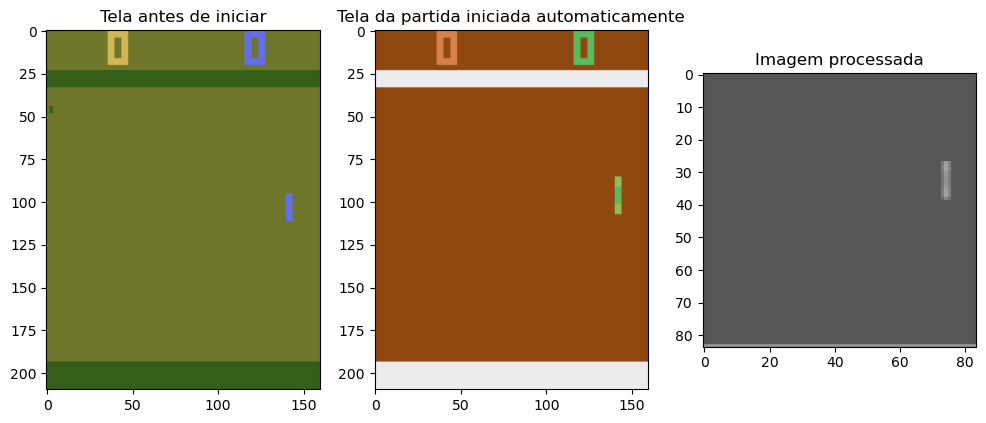

In [29]:
# Mostrando a tela do ambiente original, e outras telas após passar por alguns wrappers
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

s = env2.reset()
ax1.imshow(s)
ax1.set_title('Tela antes de iniciar')

s = env2b.reset()
ax2.imshow(s)
ax2.set_title('Tela da partida iniciada automaticamente')

s = env2d.reset()
ax3.imshow(s[0], cmap='gray', vmin=0, vmax=255)  # exibe em escala de cinza
ax3.set_title('Imagem processada');

In [30]:
DQN_TRAIN(
    env = env2f,
    env_name = ATARI_ENV_NAME,
    gamma = GAMMA,
    qnet = qnet2,
    qnet_lr = LEARNING_RATE,
    target_qnet = qtarget2,
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE,
    batch_size = BATCH_SIZE,
    epsilon_f = EPSILON_FINAL,
    epsilon_decay_period = EPSILON_DECAY_PERIOD,
    GOAL_REWARD = GOAL_REWARD)

DQNNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
0000810: finished 1 episodes, mean reward -21.000, eps 0.99, speed 537.93 steps/s
0001573: finished 2 episodes, mean reward -21.000, eps 0.98, speed 682.94 steps/s
0002336: finished 3 episodes, mean reward -21.000, eps 0.98, speed 690.17 steps/s
0003331: finished 4 episodes, mean reward -20.750, eps 0.97, speed 577.68 steps/s
0004094: finished 5 episodes, mean reward -20.800, eps 0.96, speed 682.65 steps/s
0004929: finished 6 episodes, mean reward -20.833, eps 0.95, speed 688.19 steps/s
0005848: finished 7 episodes, mean reward -20.714, eps 0.94, speed 659.35 steps/s
000

KeyboardInterrupt: 

In [ ]:
# Para carregar uma rede salva de arquivo
# Permite continuar um treinamento, ou permite carregar para salvar o vídeo
#filename = "/content/PongNoFrameskip-v4-agente-treinado.net"
#dqn_net2.load_state_dict(torch.load(filename, map_location=lambda storage,loc: storage))

In [31]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
# Atenção: precisa rodar com os wrappers aplicados!
env2 = gym.make(ATARI_ENV_NAME)
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

video_env=gym.wrappers.RecordVideo(env2f, "./dqn-atari", episode_trigger=(lambda ep : True))
test_Qpolicy(video_env, qnet2, 0.0, 2, render=False)
video_env.close()

d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\wrappers\record_video.py:41: UserWarning: WARN: Overwriting existing videos at d:\Pablo\Documents\Projects\pablo-sampaio\rl_facil\cap07\dqn-atari folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(


EPISODE 1
- steps: 763
- return: -21.0
EPISODE 2
- steps: 763
- return: -21.0
RESULTADO FINAL: média (por episódio): -21.0, episódios: 2, total de passos: 1526


In [32]:
#display_videos_from_path('./dqn-atari')
display_videos_from_path_widgets('./dqn-atari')

Playing dqn-atari\rl-video-episode-1.mp4


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x00jamdat\x00\x00\…